<a href="https://colab.research.google.com/github/marcelounb/tensorflow_udacity/blob/master/06_dogs_vs_cats_cnn_using_a_preexisting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import SGD

# Imports for the CNN
from keras.layers import Flatten 
from keras.layers.convolutional import Convolution2D 
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K 
from random import randrange

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
import os

# Part 1: Use a TensorFlow Hub MobileNet for prediction
In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier](https://tfhub.dev/s?q=tf2&module-type=image-classification) URL from tfhub.dev would work).

# Download the classifier
Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

In [3]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

# Run it on a single image
MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

65536/61306 [================================] - 0s 0us/step


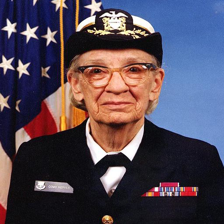

In [4]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [5]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [6]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

# Decode the predictions
To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

16384/10484 [==============================================] - 0s 0us/step


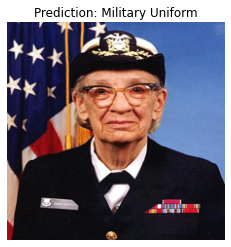

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Bingo. Our model correctly predicted military uniform!

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset
Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

# Dataset
We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [9]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteRDFQLS/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
num_examples, num_classes

(23262, 2)

The images in the Dogs vs. Cats dataset are not all the same size.

In [10]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The .repeat() and steps_per_epoch here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [12]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

Run the classifier on a batch of images
Remember our model object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes. ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Chesapeake Bay retriever', 'Tibetan mastiff', 'Siamese cat',
       'schipperke', 'affenpinscher', 'schipperke', 'tabby', 'muzzle',
       'Siamese cat', 'Great Pyrenees', 'tiger cat', 'tabby',
       'Egyptian cat', 'tabby', 'German shepherd', 'Newfoundland',
       'Siberian husky', 'schipperke', 'tabby', 'basenji', 'boxer',
       'lynx', 'golden retriever', 'Tibetan terrier', 'German shepherd',
       'Boston bull', 'flat-coated retriever', 'Pembroke', 'Egyptian cat',
       'tabby', 'flat-coated retriever', 'bloodhound'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

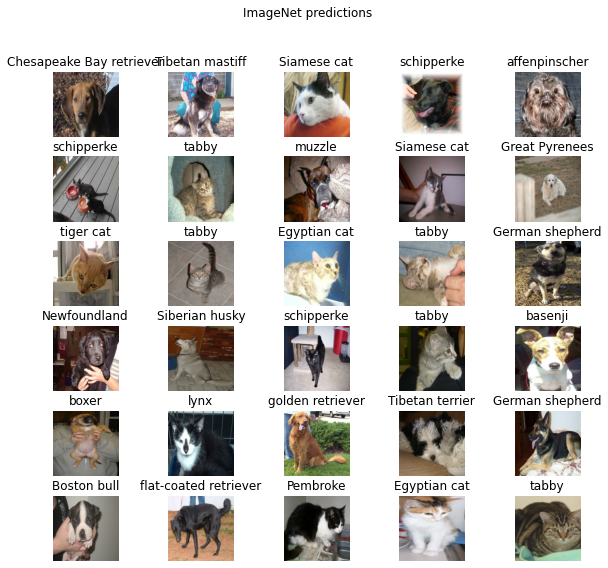

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Setting Model Parameters
For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [ ]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Augmentation
Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Putting it all together
We can apply all augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.


Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset.

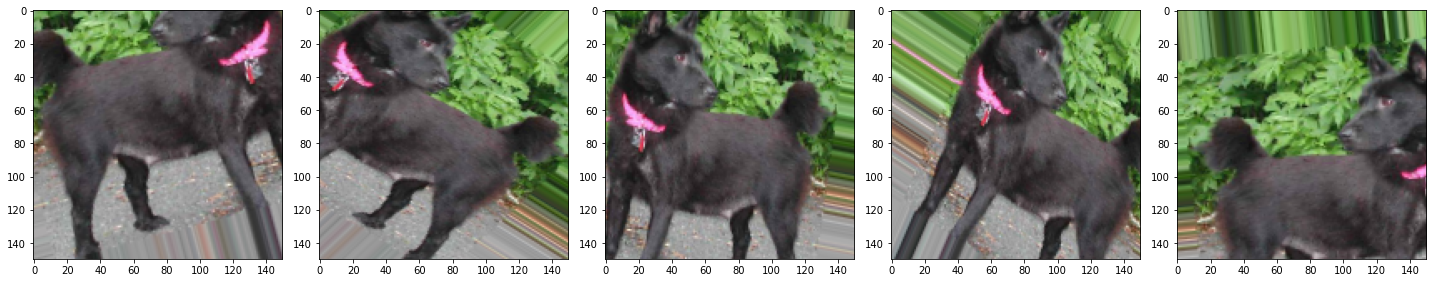

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Creating Validation Data generator
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. 

So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Model Creation

# Define the model
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax

In [ ]:
def cnn_model_my_way():
  # create model 
  model = Sequential() 
  model.add(Convolution2D(32, (3, 3), input_shape=(150, 150, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(64, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(2))

  # Compile model 
  model.compile(loss= 'sparse_categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ]) 
  return model

In [ ]:
model = cnn_model_my_way()

# Compiling the model
As usual, we will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary
Let's look at all the layers of our network using summary method.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Train the model
It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
20/20 [==============================] - 19s 947ms/step - loss: 0.7019 - accuracy: 0.5050 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 19s 949ms/step - loss: 0.6941 - accuracy: 0.5120 - val_loss: 0.6904 - val_accuracy: 0.5330
Epoch 3/100
20/20 [==============================] - 19s 948ms/step - loss: 0.6900 - accuracy: 0.5470 - val_loss: 0.6837 - val_accuracy: 0.5770
Epoch 4/100
20/20 [==============================] - 19s 950ms/step - loss: 0.6831 - accuracy: 0.5580 - val_loss: 0.6638 - val_accuracy: 0.5340
Epoch 5/100
20/20 [==============================] - 19s 966ms/step - loss: 0.6594 - accuracy: 0.5895 - val_loss: 0.6325 - val_accuracy: 0.6350
Epoch 6/100
20/20 [==============================] - 19s 973ms/step - loss: 0.6463 - accuracy: 0.6235 - val_loss: 0.6227 - val_accuracy: 0.6690
Epoch 7/100
20/20 [==============================] - 19s 966

# Visualizing results of the training
We'll now visualize the results we get after training our network.

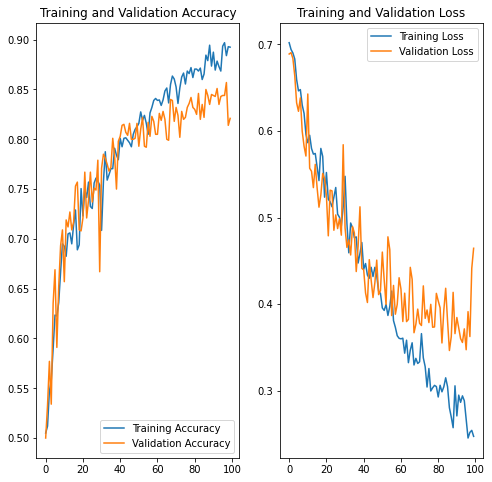

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()